Data Source: https://www.epfl.ch/labs/cvlab/data/data-em/

In [46]:
#!pip install git+https://github.com/qubvel/segmentation_models

### Important libraries

In [47]:
import tensorflow
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
from segmentation_models import get_preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from segmentation_models import Unet
from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
sm.set_framework('tf.keras')
sm.framework()


'tf.keras'

### Loading train and mask images as an array

In [48]:
train_main_path='./images/'
mask_main_path='./mask/'

In [49]:
size_x=128
size_y=128
train_images=[]
mask_images=[]
for img_path in os.listdir(train_main_path):
    image_path=train_main_path+img_path
    mask_path=mask_main_path+'training_groundtruth'+img_path[-8:]
    #print(image_path,mask_path)
    img_train=cv2.imread(image_path,0)
    img_train=cv2.resize(img_train,(size_x,size_y))
    train_images.append(img_train)
    img_mask=cv2.imread(mask_path,0)
    img_mask=cv2.resize(img_mask,(size_x,size_y))
    mask_images.append(img_mask)

### Train and mask images are visualised.

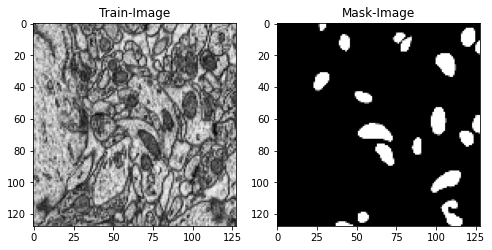

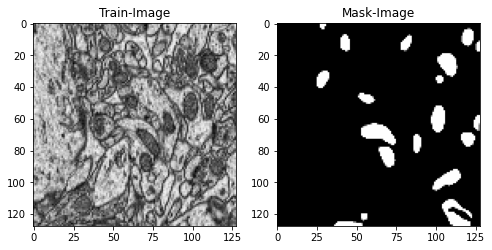

In [50]:
rcParams['figure.figsize']=8,8
for i in range(2):
  fig = plt.figure() # create the canvas for plotting
  ax1 = plt.subplot(1,2,1)
  plt.title("Train-Image")
  plt.imshow(train_images[np.random.randint(0,len(mask_images)-1)],cmap='gray')
  ax2 = plt.subplot(1,2,2)
  plt.title("Mask-Image")
  plt.imshow(mask_images[np.random.randint(0,len(mask_images)-1)],cmap='gray')
  plt.show()

### Scaling the data

In [51]:
train_images=np.array(train_images)/255.
mask_images=np.array(mask_images)/255.

### Train test split

In [52]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_images,mask_images,test_size=0.2,random_state=42)

### Preprocessing the images according to resnet

In [53]:
preprocess_input = get_preprocessing('resnet34')
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

### Model

1. The backbone model used is Resnet34.
2. The dice loss function was used.
3. The metric is the IOU Score.

In [54]:
model = sm.Unet('resnet34', encoder_weights=None,input_shape=(128,128,1))
model.compile(
    'Adam',
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)

callback=EarlyStopping(monitor='val_loss',patience=10)
model.fit(
   x=X_train,
   y=y_train,
   batch_size=4,
   epochs=50,
   validation_data=(X_test, y_test),callbacks=[callback]
)

Epoch 1/50
33/33 [==============================] - 49s 1s/step - loss: 1.0556 - iou_score: 0.1760 - val_loss: 3.6613 - val_iou_score: 0.0775
Epoch 2/50
33/33 [==============================] - 43s 1s/step - loss: 0.4515 - iou_score: 0.4593 - val_loss: 1.1533 - val_iou_score: 0.0676
Epoch 3/50
33/33 [==============================] - 43s 1s/step - loss: 0.2364 - iou_score: 0.6683 - val_loss: 1.0895 - val_iou_score: 0.0744
Epoch 4/50
33/33 [==============================] - 43s 1s/step - loss: 0.1617 - iou_score: 0.7613 - val_loss: 1.0675 - val_iou_score: 0.0978
Epoch 5/50
33/33 [==============================] - 43s 1s/step - loss: 0.1291 - iou_score: 0.8056 - val_loss: 1.1444 - val_iou_score: 0.0644
Epoch 6/50
33/33 [==============================] - 43s 1s/step - loss: 0.1063 - iou_score: 0.8369 - val_loss: 1.1103 - val_iou_score: 0.0863
Epoch 7/50
33/33 [==============================] - 44s 1s/step - loss: 0.0913 - iou_score: 0.8588 - val_loss: 1.0542 - val_iou_score: 0.1180
Epoch 

In [55]:
def plot_performance(model_history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.grid(True)
    plt.plot(model_history.history['iou_score'], 'r', label='train_iou')
    plt.plot(model_history.history['val_iou_score'], 'g', label='val_acc')
    plt.legend()
    plt.title("Train-Validation accuracy vs Epochs")
    
    plt.subplot(1,2,2)
    plt.grid(True)
    plt.plot(model_history.history['loss'], 'r--', label='train_loss')
    plt.plot(model_history.history['val_loss'], 'g--', label='val_iou')
    plt.title("Train-Validation IOU vs Epochs")
    plt.legend()
    plt.show()


### Model Evaluation at the end of each epoch

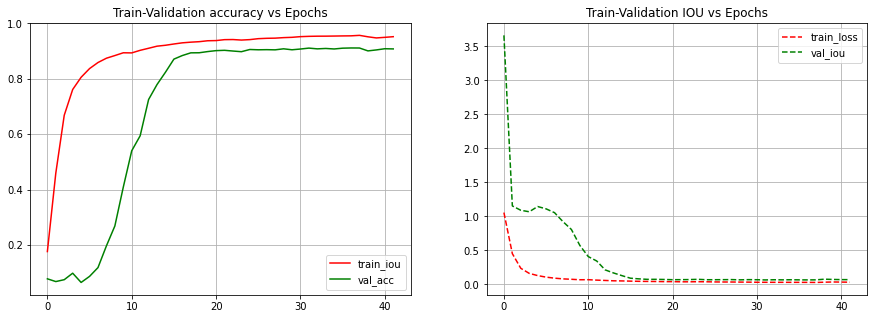

In [56]:
plot_performance(model.history)

### Testing on a Image

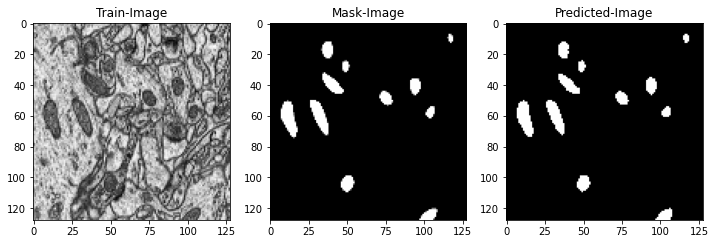

In [57]:
random_num=np.random.randint(0,10)
test=X_test[random_num].reshape(128,128)
mask=y_test[random_num].reshape(128,128)
test1=test.reshape(1,128,128,1)
pred=model.predict(test1)
pred=(pred>0.6).astype(np.uint8)
pred_image=pred.reshape(128,128)

rcParams['figure.figsize']=12,12
fig = plt.figure()
ax1 = plt.subplot(1,3,1)
plt.title("Train-Image")
plt.imshow(test,cmap='gray')

ax1 = plt.subplot(1,3,2)
plt.title("Mask-Image")
plt.imshow(mask,cmap='gray')

ax1 = plt.subplot(1,3,3)
plt.title("Predicted-Image")
plt.imshow(pred_image,cmap='gray')
plt.show()

**Conclusion**

Our model is good because the mask image and the predicted image are nearly identical.